In [21]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from random import seed
from random import random

In [22]:
# This funtion generates data 
np.random.seed(42)
def data_generator(n):
    As = []    
    x = np.random.normal(0,1,size = (n,2)) # n is the size of sample
    noise = np.random.normal(0,0.04**2) 
    
    for condition_number in [1,0.1,0.01,0.001]: # create a list of As with different conditional number
        A = np.matrix([[1, 1], [1, 1+condition_number]])
        As.append(A)
        
    y1 = np.dot(x,As[0]) + 0.01*noise #compute y with different A
    y01 = np.dot(x,As[1]) + 0.01*noise
    y001 = np.dot(x,As[2]) + 0.01*noise
    y0001 = np.dot(x,As[3]) + 0.01*noise
    
    x = torch.Tensor(x).float() #convert all ndarrays to tensors
    y1 = torch.Tensor(y1).float()
    y01 = torch.Tensor(y01).float()
    y001 = torch.Tensor(y001).float()
    y0001 = torch.Tensor(y0001).float()
       
    return x, y1, y01, y001, y0001    

In [43]:
#set up weight for the first layer
np.random.seed(42)

w1 = w11 = np.random.rand()
w3 = -w11
w2 = w12 = np.random.rand()
w4  = -w12
w5 = w21 = np.random.rand()
w7 = -w21
w6 = w22 = np.random.rand()
w8 = -w22

K1 = torch.Tensor([[w1,w2],[w3,w4],[w5,w6],[w7,w8]])

#set up weights for the second layer
K2 = torch.Tensor([[1,-1,0,0],[0,0,1,-1]])

# print(K1.shape,'\n')
# print(K2.shape)
print (w1,w3,w2,w4,w5,w7,w6,w8)

0.3745401188473625 -0.3745401188473625 0.9507143064099162 -0.9507143064099162 0.7319939418114051 -0.7319939418114051 0.5986584841970366 -0.5986584841970366


In [44]:
def calculate_loss(output,trainy):
    return ((torch.norm(output-trainy))**2)/10000

In [45]:
# Define the network structure
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 4) #initializing nodes
        self.fc1.weight.data = K1 #initializing weights       
        print("fc1 weight:",self.fc1.weight.data)
        nn.init.zeros_(self.fc1.bias) #initializing bias to zeros


        self.fc2 = nn.Linear(4, 2) 
        self.fc2.weight.data = K2
        print("fc2 weight:",self.fc2.weight.data)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        hidden = self.fc1(x) #apply the Relu activation function F.relu(
        output = self.fc2(hidden)
        return output

model = NN()
model = model.float()
criterion = nn.MSELoss() #uses MSE function from sikit learn to calculate the loss
optimizer = optim.SGD(model.parameters(), lr=0.001) #SGD = Stochastic Gradient Decscent, lr = learning rate

fc1 weight: tensor([[ 0.3745,  0.9507],
        [-0.3745, -0.9507],
        [ 0.7320,  0.5987],
        [-0.7320, -0.5987]])
fc2 weight: tensor([[ 1., -1.,  0.,  0.],
        [ 0.,  0.,  1., -1.]])


In [58]:
# use this function to run the neural network
def run_net(train_x,train_y,epochs): 
    epochs = epochs
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_ll = [] 
    batch_size = len(train_x) # set batch size to the length of data
    model.to(device)

    for epoch in range(epochs):
        permutation = torch.randperm(train_x.size()[0])
        for i in range(0, train_x.size()[0],batch_size):
            
            optimizer.zero_grad() 
            indices = permutation[i:i+batch_size]
            batch_x, batch_y = train_x[indices], train_y[indices] 
            
            outputs = model.forward(batch_x)  #feed the train x to get prediction      
#             loss = criterion(outputs,batch_y)  #compare the prediction, train y and get the loss
            loss = calculate_loss(outputs,batch_y)
            train_ll.append(loss)
            loss.backward() #do back propagation
            optimizer.step() #update the weights
            
    return train_ll 


#             print(f"Epoch {epoch+1}/{epochs}.. "
#                   f"Train loss: {loss:.3f}.. ")

In [61]:
def main(n,epochs):
    

    train_x_all, train_y_1,train_y_01,train_y_001,train_y_0001= data_generator(n) # fetch the data 
    
    list_1 = run_net(train_x_all,train_y_1,epochs) #collecting the loss and put them in to according list
    print("1",list(model.parameters()),"\n")
    list_01 = run_net(train_x_all,train_y_01,epochs)
    print("01",list(model.parameters()),"\n")
    list_001 = run_net(train_x_all,train_y_001,epochs)
    print("001",list(model.parameters()),"\n")
    list_0001 = run_net(train_x_all,train_y_0001,epochs) 
    print("0001",list(model.parameters()),"\n")
    print(list_1)
    
    plt.plot(list_1)
    plt.plot(list_01)
    plt.plot(list_001)
    plt.plot(list_0001)

#     # plot 3000 epochs and the losses
#     epochs = 3000
#     plt.suptitle('Forward Problem')
#     plt.plot(range(epochs),list_1)
#     plt.plot(range(epochs),list_01)
#     plt.plot(range(epochs),list_001)
#     plt.plot(range(epochs),list_0001)
# #     x1,x2,y1,y2 = plt.axis()
# #     plt.axis((x1,x2,0,0.1))
    plt.xlabel('Number of Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend(['1', '0.1', '0.01', '0.001'], loc='upper right')
    plt.show()

#     # plot the first 1000 epochs
#     epochs = 1000
#     plt.suptitle('Forward Problem')
#     plt.plot(range(epochs),list_1[:1000])
#     plt.plot(range(epochs),list_01[:1000])
#     plt.plot(range(epochs),list_001[:1000])
#     plt.plot(range(epochs),list_0001[:1000])
#     x1,x2,y1,y2 = plt.axis()
#     plt.axis((x1,x2,0,0.1))
#     plt.xlabel('Number of Epochs')
#     plt.ylabel('Mean Squared Error')
#     plt.legend(['1', '0.1', '0.01', '0.001'], loc='upper right')
#     plt.show()

1 [Parameter containing:
tensor([[ 0.6150,  0.6647],
        [-0.6150, -0.6647],
        [ 0.4247,  0.9000],
        [-0.4247, -0.9000]], requires_grad=True), Parameter containing:
tensor([-8.4593e-05,  8.4593e-05, -6.1061e-05,  6.1061e-05],
       requires_grad=True), Parameter containing:
tensor([[ 0.8763, -0.8763, -0.0916,  0.0916],
        [ 0.0932, -0.0932,  1.0423, -1.0423]], requires_grad=True), Parameter containing:
tensor([0.0001, 0.0001], requires_grad=True)] 

01 [Parameter containing:
tensor([[ 0.6329,  0.6391],
        [-0.6329, -0.6391],
        [ 0.5642,  0.6202],
        [-0.5642, -0.6202]], requires_grad=True), Parameter containing:
tensor([-8.7817e-05,  8.7817e-05, -7.6353e-05,  7.6353e-05],
       requires_grad=True), Parameter containing:
tensor([[ 0.8749, -0.8749, -0.0953,  0.0953],
        [-0.0064,  0.0064,  0.8934, -0.8934]], requires_grad=True), Parameter containing:
tensor([0.0001, 0.0001], requires_grad=True)] 

001 [Parameter containing:
tensor([[ 0.6354,  0

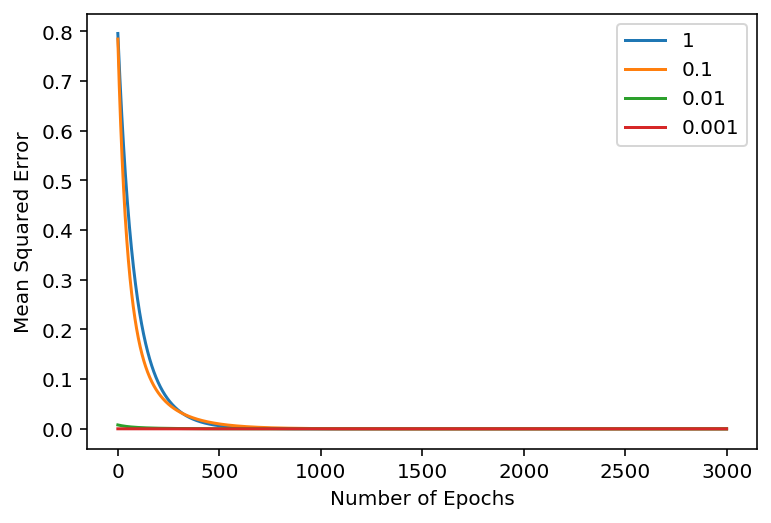

In [65]:
# To use the forward net, use the function below
main(10000,3000) #main(number of samples, number of epochs)

In [67]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.6357,  0.6358],
         [-0.6357, -0.6358],
         [ 0.5825,  0.5831],
         [-0.5825, -0.5831]], requires_grad=True), Parameter containing:
 tensor([-8.7926e-05,  8.7926e-05, -7.7829e-05,  7.7829e-05],
        requires_grad=True), Parameter containing:
 tensor([[ 0.8744, -0.8744, -0.0959,  0.0959],
         [-0.0200,  0.0200,  0.8801, -0.8801]], requires_grad=True), Parameter containing:
 tensor([0.0001, 0.0001], requires_grad=True)]